In [85]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import itertools

from sklearn.metrics import recall_score, accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
# open the pre-processed csv file and split the target variable from the classifiers
df = pd.read_csv('dota2_cleaned.csv')

# Shuffle the dataframe before the train test split  
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
#separate the target variable
labels = df[['Won']]
df.drop(['Won'], axis=1, inplace=True)

In [4]:
def print_metrics(labels, predictions, print_score=None):
    ''' This function receives model predictions along with the actual labels
        and returns the precision score, recall, accuracy and F1'''
    
    recall = round(recall_score(labels, predictions)*100, 2)
    acc = round(accuracy_score(labels, predictions)*100, 2)
    
    if print_score:
        print(f"Recall Score: {recall}")
        print(f"Accuracy Score: {acc}")
        
    return recall, acc

In [104]:
def plot_confusion_matrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    plt.imshow(matrix,  cmap=plt.cm.Blues)

    #Add title and Axis Labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    #Add appropriate Axis Scales
    class_names = set(y_test)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Add Labels to Each Cell
    thresh = matrix.max() / 2. #Used for text coloring below
    
    #iterate through the confusion matrix and append the labels
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
            plt.text(j, i, matrix[i, j],
                     horizontalalignment="center",
                     color="white" if matrix[i, j] > thresh else "black")

    #Add a Side Bar Legend Showing Colors
    plt.colorbar()

In [5]:
# create seprate training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.25)

#   KNN Model:

In [6]:
from sklearn.neighbors import KNeighborsClassifier
# run initial model with default values
knn = KNeighborsClassifier()
knn.fit(x_train, y_train.values.ravel())

knn_pred = knn.predict(x_test)

k5recall, k5acc = print_metrics(y_test, knn_pred, print_score=True)

Recall Score: 52.18
Accuracy Score: 50.85


In [7]:
knn_cm = (y_test, knn_pred)

In [ ]:
# find the most important features

## Initial KNN model performed slightly better than random guess 
Recall Score: 53.25%

Accuracy Score: 51.72%

In [8]:
def multiple_knn(df, labels, ks=[5]):
    x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.3)
    best_acc = 0
    best_k = 0
    scores = []

    for k in tqdm(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train.values.ravel())
        test_predict = knn.predict(x_test)
        score = print_metrics(y_test, test_predict)
        scores.append(score)
        
        if best_acc < score[1]:
            best_acc = score[1]
            best_k = k
            
        
    return best_acc, best_k, scores

In [9]:
# run model again k = 4, 6, 7, 8, 9
acc, k, scores = multiple_knn(df, labels, ks=[4, 6, 7, 8, 9])
print(f"scores: {scores}, k: {k}")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.61s/it]


scores: [(35.66, 51.71), (38.12, 51.42), (53.43, 51.39), (39.88, 51.7), (53.18, 51.63)], k: 4


In [10]:
# run model again k = 4, 10, 11, 12
acc, k, scores = multiple_knn(df, labels, ks=[4, 10, 11, 12])
print(f"scores: {scores}, k: {k}")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:34<00:00, 38.45s/it]


scores: [(35.12, 51.68), (40.29, 51.62), (52.65, 51.73), (42.94, 52.24)], k: 12


### KNN = 12


#### Recall - 42.94% 

#### Accuracy = 52.24%


In [12]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(x_train, y_train.values.ravel())

k12_predict = knn.predict(x_test)

k12recall, k12acc = print_metrics(y_test, k12_predict, print_score=True)

Recall Score: 42.19
Accuracy Score: 51.76


# Decision Trees

In [53]:
from sklearn.tree import DecisionTreeClassifier 
# run initial model to evaluate the base line
from sklearn import tree 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.pipeline import make_pipeline

D:\Programs\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [63]:
tree = DecisionTreeClassifier(random_state=10)  
tree.fit(x_train, y_train)

# predict
tree_pred = tree.predict(x_test)

# get prediction accuracy
tree_recall, tree_acc = print_metrics(y_test, tree_pred, print_score=True)

Recall Score: 52.48
Accuracy Score: 52.39


In [44]:
# Identify the optimal tree depth for given data
def find_optimal_depth(x_train, x_test, y_train, y_test):   
    #declare variables
    max_depths = np.linspace(1, 10, 10, endpoint=True)
    train_results = []
    test_results = []
    # iterate over the different depths
    for depth in max_depths:
        trees = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        trees.fit(x_train, y_train)
        
        # Add auc score to train list
        train_pred = trees.predict(x_train)
        fpr, tpr, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(fpr, tpr)
        train_results.append(roc_auc)
        
        # Add auc score to test list
        test_pred = trees.predict(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, test_pred)
        roc_auc = auc(fpr, tpr)
        test_results.append(roc_auc)
        
    plt.figure(figsize=(12,6))
    plt.plot(max_depths, train_results, 'b', label='Train AUC')
    plt.plot(max_depths, test_results, 'r', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Tree depth')
    plt.legend()
    plt.show()
    pass

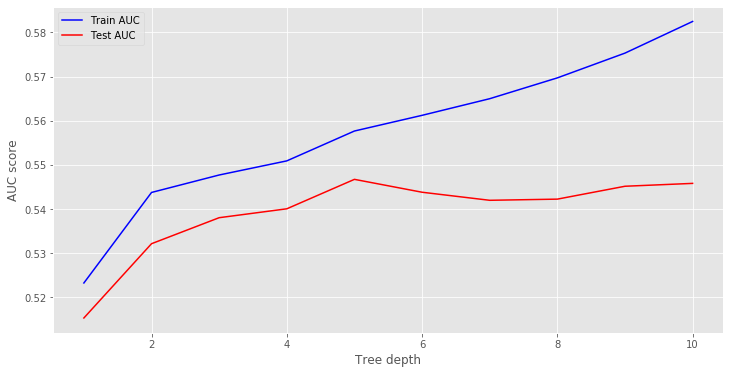

In [46]:
# find the optimal depth
find_optimal_param(x_train, x_test, y_train, y_test)

In [64]:
tree_param_grid = {'criterion': ['entropy'],
                  'max_depth': [3, 4, 6, 7],
                  'min_samples_split': [3, 5, 6, 7],
                  'min_samples_leaf': [3, 4, 5, 6]
                  }               

tree_gs = GridSearchCV(tree, param_grid=tree_param_grid, scoring='accuracy', cv=5)
tree_grid = tree_gs.fit(x_train, y_train.values.ravel())

D:\Programs\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [65]:
print(tree_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 3}


In [70]:
# fit the optimal tree
optimal_tree = tree_grid.best_estimator_
optimal_tree.fit(x_train, y_train)
# predict
opt_tree_pred = optimal_tree.predict(x_test)

# get prediction accuracy
opt_tree_recall, opt_tree_acc = print_metrics(y_test, opt_tree_pred, print_score=True)

Recall Score: 46.62
Accuracy Score: 54.4


### Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 3}

#### Recall - 46.62% 

#### Accuracy = 54.39%

# Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [72]:
# get a baseline how random forest performs
forest = RandomForestClassifier(random_state=10)
forest.fit(x_train, y_train.values.ravel())

# predcit
forest_test_pred = forest.predict(x_test)

# testing accuracy
f_recall, f_acc = print_metrics(y_test, forest_test_pred, print_score=True)

D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Recall Score: 41.37
Accuracy Score: 52.49


### Random Forest Using Gridsearch

In [73]:
# define params grid
forest_param_grid = {'criterion': ['gini', 'entropy'],
                     'max_depth': [3, 4, 6, 7],
                     'min_samples_split': [3, 5, 6, 7, 10, 15],
                     'min_samples_leaf': [3, 4, 5, 6, 9, 12]
                    }                    

In [76]:
# Use grid search to find the best paramers for random forest
forest_search = GridSearchCV(forest, forest_param_grid, cv=3, verbose=1, scoring='accuracy')
forest_search.fit(x_train, y_train.values.ravel())

# predcit the testing data
forest_grid_test_pred = forest_search.predict(x_test)

# test how the model performs 
forest_grid_recall, forest_grid_acc = print_metrics(y_test, forest_grid_test_pred, print_score=True)
best_forest_params = forest_search.best_params_

#best paramters
print(f"Best paramaters: {best_forest_params}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:  1.5min finished


Recall Score: 55.38
Accuracy Score: 55.23
Best paramaters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}


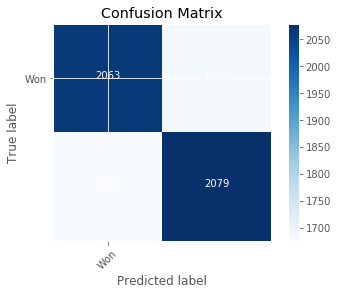

In [105]:
plot_confusion_matrix(y_test, forest_grid_test_pred)

#### Optimal Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 7}

Accuracy = 55.23%

# AdaBoost

In [77]:
# get a baseline on how ada boost performs
adaboost = AdaBoostClassifier()
adaboost.fit(x_train, y_train.values.ravel())

# predict
adaboost_test_pred = adaboost.predict(x_test)

# test how the model performs 
ada_recall, ada_accuracy = print_metrics(y_test, adaboost_test_pred, print_score=True)

Recall Score: 56.21
Accuracy Score: 56.41


In [ ]:
plot_confusion_matrix(y_test, adaboost_test_pred, classes=['Won', 'Lost'], title='Won or Lost')

### AdaBoost Using Gridsearch

In [78]:
adaboost_param_grid = {'n_estimators': [70, 150, 200, 250, 270, 300],
                       'learning_rate': [0.4, 0.2, 0.1]
                      }

In [80]:
#fit adaboost with a paramters grid
ada_grid_search = GridSearchCV(adaboost, adaboost_param_grid, scoring='accuracy', cv=4)
ada_grid_search.fit(x_train, y_train.values.ravel())

# predict 
adagrid_pred = ada_grid_search.predict(x_test)

# test how well the model performs 
adagrid_recall, adagrid_accuracy = print_metrics(y_test, adagrid_pred, print_score=True)

#best paramters
best_ada_params = ada_grid_search.best_params_

Recall Score: 54.87
Accuracy Score: 56.36


In [90]:
#changing the hyper paramaters
adaboost_param_grid2 = {'n_estimators': [50, 70, 100, 150,],
                       'learning_rate': [0.6, 0.5, 0.4, 0.3]
                      }

# fitting a new model with different hyper paramaters
ada_grid_search2 = GridSearchCV(adaboost, adaboost_param_grid2, scoring='accuracy', cv=4)
ada_grid_search2.fit(x_train, y_train.values.ravel())

# predict 
adagrid_pred2 = ada_grid_search2.predict(x_test)

# test how well the model performs 
adagrid_recall2, adagrid_accuracy2 = print_metrics(y_test, adagrid_pred2, print_score=True)

#best paramters
best_ada_params2 = ada_grid_search2.best_params_

Recall Score: 54.87
Accuracy Score: 56.36


In [81]:
print(best_ada_params2)

{'learning_rate': 0.4, 'n_estimators': 150}


### Optimal Parameters: {learning_rate': 0.4, 'n_estimators': 150}
#### Score = 56.36%

# XGBoost

In [98]:
import xgboost as xgb

# check baseline accuracy for xgboost
xgbooster = xgb.XGBClassifier()
xgbooster.fit(x_train, y_train.values.ravel())

# predict
xgb_pred = xgbooster.predict(x_test)

# test how well the model performs 
xgb_recall, xgb_accuracy = print_metrics(y_test, xgb_pred, print_score=True)

Recall Score: 53.7
Accuracy Score: 55.91


In [ ]:
plot_confusion_matrix(y_test, xgb_pred, classes=['Won', 'Lost'], title='Won or Lost')

In [ ]:
xgbooster.feature_importances_

### XGBoost Using Gridsearch

In [102]:
xg_param_grid = {'learning_rate': [0.2, 0.4], 'max_depth': [7], 
                 'min_child_weight': [5, 6], 'subsample': [0.7],
                 'n_estimators': [100, 120, 150]
                }

In [103]:
xg_grid = GridSearchCV(xgbooster, xg_param_grid, scoring='accuracy', cv=3, n_jobs=1)
xg_grid.fit(x_train, y_train.values.ravel())


# predict
xg_grid_preds = xg_grid.predict(x_test)

# test how well the model performs 
xg_grid_recall, xg_grid_acc = print_metrics(y_test, xg_grid_preds, print_score=True)
best_parameters = xg_grid.best_params_

print(best_parameters)

Recall Score: 54.85
Accuracy Score: 55.6
{'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}


In [ ]:
xg_grid.

In [ ]:
'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}
0.708952380952381
0.7056666666666667

In [ ]:
def feature_importance(model, x_train):
    importances = model.feature_importances_
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
     
    if indices > 10:
        indices = indices[::10]
        features = x_train.shape[1]


In [ ]:
plt.figure(figsize=(20, 20))
plt.barh(range(x_train.shape[1]), xgbooster.feature_importances_, align='center')
plt.yticks(np.arange(x_train.shape[1]), x_train.columns.values)
plt.xlabel("Feature importance")
plt.ylabel("Feature")

In [ ]:
def plot_feature_importances(model):
   n_features = X_train.shape[1]
   plt.figure(figsize=(8,8))
   plt.barh(range(n_features), model.feature_importances_, align='center')
   plt.yticks(np.arange(n_features), X_train.columns.values)
   plt.xlabel("Feature importance")
   plt.ylabel("Feature")

In [ ]:
a = np.argsort(xgbooster.feature_importances_)[::-1]

In [ ]:
xgbooster.feature_importances_

In [ ]:
a[10::]